In [1]:
library(tidyverse)
library(broom)
library(caret)
list.files(path = "../input")

.... = NA

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.4     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress




[1] "bda-2021-physical-activity-recognition"

# Overview

Writers: 
* Mathilde ter Veen 
* Jessica Bormann 
* Ini Zwart


In this assignment, we tried to assess the signals measured by an accelerometer and gyrometer on a smart phone. The signals can be classified by twelve labels, indicating the kind of activity. We tried to predict the kind of activity that was performed per signal. Accuracy was taken as measurement to quantify the prediction.

In [2]:
# Make sure the data is available
if (length(list.files("../input", pattern = "recognition")) > 0) {
    
    # Copy all files to the current directory
    system("cp -r ../input/bda-2021-physical-activity-recognition/* ./")
    
} else {
    
    # Download data for this competition
    data_url = "https://phonesensordata.netlify.app/Archive.zip"
    download.file(data_url, "Archive.zip")

    # Unzip all files in the current directory
    unzip("Archive.zip")
    
}

# list files in the current working directory
list.files()

# show the content of the labels file 
file.show("activity_labels.txt")

[1] "__notebook__.ipynb"     "activity_labels.txt"    "example_submission.csv"
[4] "RawData"                "README.txt"


# 1. Reading the data


The data are stored in text files. 

- There are text files that store the signals for each user for each experiment (trial; 3 trials per person).
- There is a text file that stores the activity labels for segments of signals for all participants for each experiment.

The code below does most of the heavy lifting for you.

# 1.1 Import Activity labels

First import the activity labels:

In [3]:
act_labels = read_delim("activity_labels.txt"," ",col_names=F,trim_ws=T) 
act_labels = act_labels %>% select(X1,X2)
act_labels 


── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  X2 = col_character(),
  X3 = col_logical()
)


Warning message:
“1 parsing failure.
row col  expected    actual                  file
  3  -- 3 columns 2 columns 'activity_labels.txt'
”


X1,X2
<dbl>,<chr>
1,WALKING
2,WALKING_UPSTAIRS
3,WALKING_DOWNSTAIRS
4,SITTING
5,STANDING
6,LAYING
7,STAND_TO_SIT
8,SIT_TO_STAND
9,SIT_TO_LIE


The signals themselves are stored in text files. In these files there are three columns; each column is the signal measured in one of the 3 channels of the sensor (these channels are associated in X, Y and Z direction). Each signal consists of a sequence of measurements, called _samples_.

For each subject the file `/archive/RawData/labels.txt` stores the trial number, user ID, activity together with the sample number at which the activity started, and the sample number at which time the activity ended.

In [4]:
labels = read_delim("./RawData/Train/labels_train.txt", " ", col_names = F)
colnames(labels) <- c('trial', 'userid', 'activity', 'start', 'end')

labels = labels %>% mutate(activity = act_labels$X2[activity])

print(labels)


── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double()
)




# A tibble: 849 x 5
   trial userid activity     start   end
   <dbl>  <dbl> <chr>        <dbl> <dbl>
 1     1      1 STANDING       250  1232
 2     1      1 STAND_TO_SIT  1233  1392
 3     1      1 SITTING       1393  2194
 4     1      1 SIT_TO_STAND  2195  2359
 5     1      1 STANDING      2360  3374
 6     1      1 STAND_TO_LIE  3375  3662
 7     1      1 LAYING        3663  4538
 8     1      1 LIE_TO_SIT    4539  4735
 9     1      1 SITTING       4736  5667
10     1      1 SIT_TO_LIE    5668  5859
# … with 839 more rows


The data frame encodes the `start` and `end` sample for each subsequent activity in signal files, for each `trial` and `userid`.  

What should be noticed is that some activities were repeated at different times during the recording, which results in multiple time (sample) windows in which the participant was for instance `WALKING_UPSTAIRS`.

For each user there are several files. Although you may be inclined to think in terms of "users" (as they are participants), it's easier to focus on the files, because there in some cases multiple files per user.

Here we'll import only the files of which the filename starts with 'acc' (for 'accelorometer' as opposed to 'gyroscope'). 

The filenames contain information about the participant ID (prefixed with `user`), and about the experimental run (prefixed with `exp`). The latter isn't very usefull, but we will need it anyway extract the proper rows from the `labels` data frame above. We need to retain this information, and therefore we use "regular expressions" to extract them


In [5]:
# identify the file name and extract the 'username' (participant ID) and 'expname' (experimental run)
filename = "RawData/Train/acc_exp01_user01.txt"
username = gsub(".+user(\\d+).+", "\\1", filename) %>% as.integer()
expname  = gsub(".+exp(\\d+).+", "\\1", filename) %>% as.integer()

# import the data from the file
user01 = read_delim(filename, " ", col_names = F)


── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double()
)




# 1.2 Import the signals

Let's have a peek at the imported data:

In [6]:
head(user01)

X1,X2,X3
<dbl>,<dbl>,<dbl>
0.9180556,-0.11250000,0.5097223
0.9111111,-0.09305556,0.5375000
0.8819445,-0.08611111,0.5138889
0.8819445,-0.08611111,0.5138889
0.8791667,-0.10000000,0.5055556
0.8888890,-0.10555556,0.5125000


Each column is a signal. Subsequent rows are subsequent measurement samples, and so we treat rownumber as a time indicator (to keep the distinction clear we'll talk about sample number).

Let's have a look at the signal wave forms:


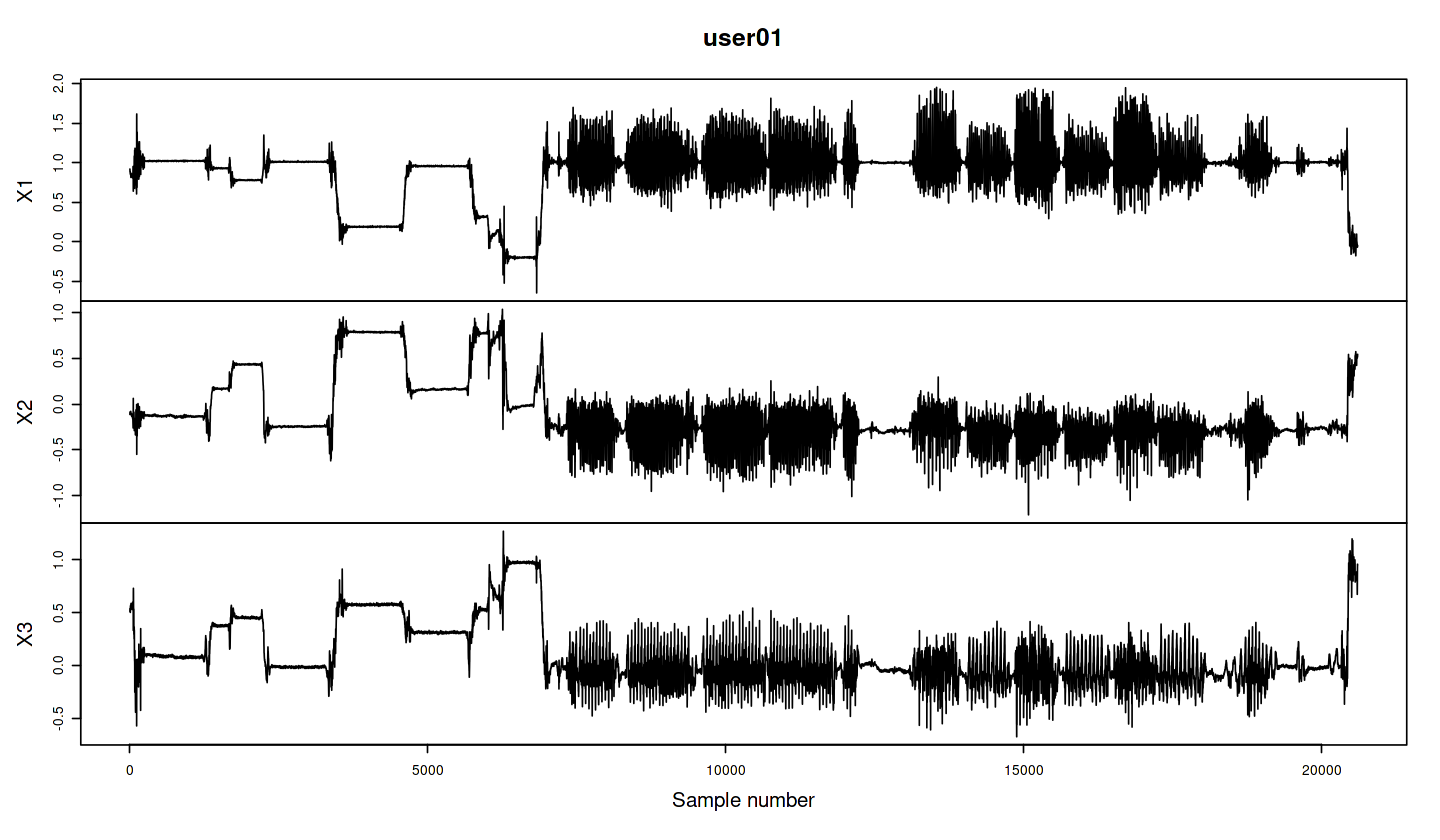

In [7]:
options(repr.plot.width=12)

plot.ts(user01, xlab="Sample number")

Clearly different segments from horizontal axis correspond to different activities. We need to label different samples with the corresponding activity.


# 1.3 Merging Signals and Labels

The data frame `labels` contains this information, but in a somewhat odd format: Each row specifies at which samples an activity for a given participant in a given experimental run started and ended. For example, the first two rows


In [8]:
print(labels[1:2,])

# A tibble: 2 x 5
  trial userid activity     start   end
  <dbl>  <dbl> <chr>        <dbl> <dbl>
1     1      1 STANDING       250  1232
2     1      1 STAND_TO_SIT  1233  1392


It is much handier to have a data frame that gives an activity label for each `trial`, `userid` and each time `sampleid`. We can compute this from the `labels` data frame with a nifty feature that you may not know about: Cells in a `tibble` can contain a `list()`. This is usefull for storing groups of values that all share the same values on other variables. Tibbles with such cells are called "nested". They can be expanded to a normal `tibble` or data frame with the `dplyr::unnest()` function. We'll use above `label` data frame to demonstrate this: First we add the sequence `start:end` inside a `list()` to each row of `labels`. For instance, the first two rows above become 

```
  trial userid activity     start   end sampleid 
  <dbl>  <dbl> <chr>        <dbl> <dbl> <list>   
1     1      1 STANDING       250  1232 list( 250:1232)
2     1      1 STAND_TO_SIT  1233  1392 list(1233:1392)
```

In [9]:
# Add the sequence start:end to each row in a list.
# The result is a nested table:
sample_labels_nested = 
    labels %>% 
    rowwise() %>% # do next operation(s) rowwise
    mutate(sampleid = list(start:end)) %>%
    ungroup()

# Check the resulting table:
print(sample_labels_nested, n=6) 

# A tibble: 849 x 6
  trial userid activity     start   end sampleid     
  <dbl>  <dbl> <chr>        <dbl> <dbl> <list>       
1     1      1 STANDING       250  1232 <int [983]>  
2     1      1 STAND_TO_SIT  1233  1392 <int [160]>  
3     1      1 SITTING       1393  2194 <int [802]>  
4     1      1 SIT_TO_STAND  2195  2359 <int [165]>  
5     1      1 STANDING      2360  3374 <int [1,015]>
6     1      1 STAND_TO_LIE  3375  3662 <int [288]>  
# … with 843 more rows


Note that dplyr prints only a summary of the 'sampleid' column, in a rather abstract way (e.g., `<int [983]>` under `sampleid` means: `sampleid` contains 983 integers for row 1).


Next we unnest the nested tibble `sample_labels_nested` to obtain a table that for each `sampleid` value stores the right `activity` label. There is however one issue: Each row corresponds to a signal segment of an activity. Some of the activities, such as WALKING, were done multiple times in the same experiment in different time segments. We need to be able to identify different segments of WALKING. Therefore, before unnesting, we'll add the row numbers as `segment` ID:


In [10]:
# Unnest the nested tabel.
sample_labels = 
    sample_labels_nested %>% 

    # Rows are segments, we need to keep track of different segements
    mutate(segment = row_number() ) %>% 

    # Expand the data frame to one sample per row
    unnest() %>% 

    # Remove columns we don't need anymore
    select(-start, -end) 


# Check the result (first few rows are not interesting; rows 977-990 are)
print(sample_labels[977:990, ])

Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(sampleid)`”


# A tibble: 14 x 5
   trial userid activity     sampleid segment
   <dbl>  <dbl> <chr>           <int>   <int>
 1     1      1 STANDING         1226       1
 2     1      1 STANDING         1227       1
 3     1      1 STANDING         1228       1
 4     1      1 STANDING         1229       1
 5     1      1 STANDING         1230       1
 6     1      1 STANDING         1231       1
 7     1      1 STANDING         1232       1
 8     1      1 STAND_TO_SIT     1233       2
 9     1      1 STAND_TO_SIT     1234       2
10     1      1 STAND_TO_SIT     1235       2
11     1      1 STAND_TO_SIT     1236       2
12     1      1 STAND_TO_SIT     1237       2
13     1      1 STAND_TO_SIT     1238       2
14     1      1 STAND_TO_SIT     1239       2


Now that we have each sample labeled with an activity, we can add the corresponding signals values that are stored in `user01`.

Let's put the signals `user01` in a data frame in which we include the `userid`, the `trial` number, and a `sampleid` for each row in `user01`. Then we'll use a `left_joint()` to merge the activity labels: 

In [11]:
user_df = 
    # Store signals user01 in a data frame, with 'userid' and 'trial'
    data.frame(userid = username, trial = expname, user01) %>%

    # Add 'sampleid' for matching the sampleid's in 'sample_labels'. 
    # The first sample in user01 signals always has sampleid=0; the last
    # has sampleid is therefore nrow(user01)-1.
    mutate(sampleid = 0:(nrow(user01)-1) ) %>%

    # Add the labels stored in sample_labels
    left_join(sample_labels) 

# Check the result (first few rows are not interesting; the following are)
print(user_df[1227:1239, ])

Joining, by = c("userid", "trial", "sampleid")



     userid trial       X1         X2         X3 sampleid     activity segment
1227      1     1 1.022222 -0.1375000 0.07500000     1226     STANDING       1
1228      1     1 1.019445 -0.1347222 0.07361111     1227     STANDING       1
1229      1     1 1.022222 -0.1375000 0.07777778     1228     STANDING       1
1230      1     1 1.025000 -0.1375000 0.07638889     1229     STANDING       1
1231      1     1 1.030556 -0.1444445 0.07916667     1230     STANDING       1
1232      1     1 1.016667 -0.1430556 0.05833334     1231     STANDING       1
1233      1     1 1.015278 -0.1416667 0.05972222     1232     STANDING       1
1234      1     1 1.020833 -0.1638889 0.05555556     1233 STAND_TO_SIT       2
1235      1     1 1.027778 -0.1736111 0.06944445     1234 STAND_TO_SIT       2
1236      1     1 1.025000 -0.1638889 0.05833334     1235 STAND_TO_SIT       2
1237      1     1 1.022222 -0.1472222 0.04861111     1236 STAND_TO_SIT       2
1238      1     1 1.022222 -0.1597222 0.04305556    

This table is exactly what we need: Each sample from signals in `X1`, `X2`, and `X3` now are labeled with an `activity`.


To visualize the result, use `ggplot()` which makes it allows to give different signal segments different colors to label the activity in that segment:

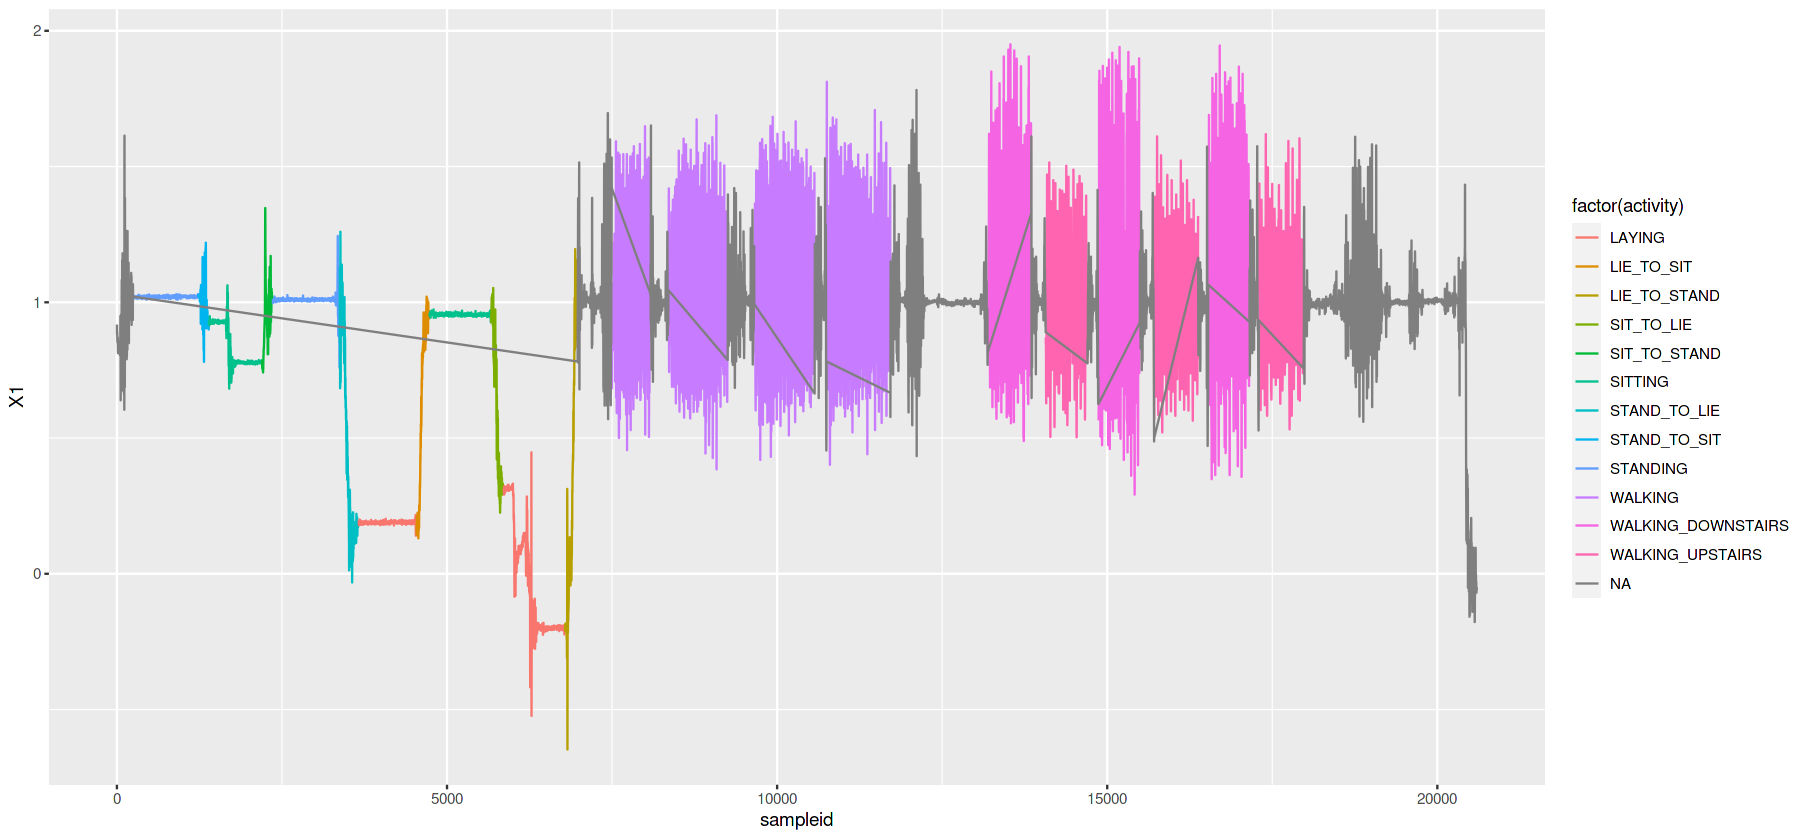

In [12]:
options(repr.plot.width=15) # change plot width for nicer output

user_df %>% 
  ggplot(aes(x = sampleid, y = X1, col = factor(activity), group=segment)) + 
      geom_line()  

*Note: In the plot you'll notice the weird gray lines crossing through the plot. The gray trace corresponds to non-labeled segments (labeled `NA` in the legend of the plot). The segments that are labeled with an activity are interspersed with short unlabeled segments, which are drawn in gray, which causes the gray trace to connect different unlabeled segments.*


# 2. Feature Extraction

Now we are ready to extract features that can be used by the various classification algorithms.


# 2.1 Time domain features

For the classification algorithms discussed in chapter 4 of ISLR, the time samples themselves are not useful features. To see this, consider the following plot which shows segments with typical walking cycles (hand picked by closely inspecting the signals).


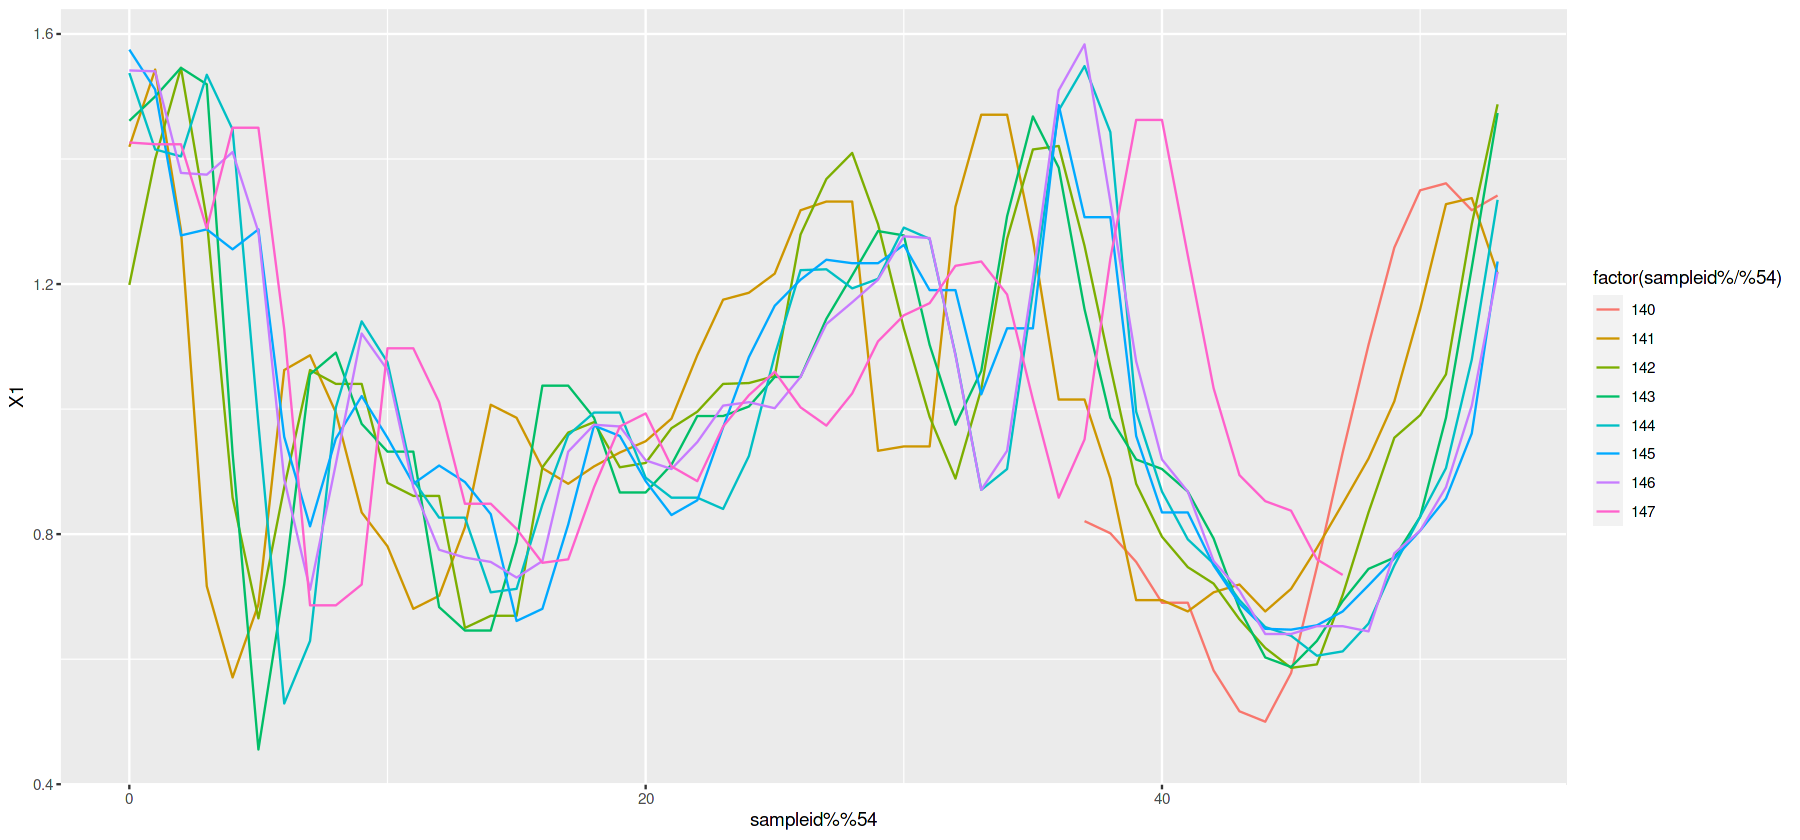

In [13]:
user_df %>% 

  # change 7986 to 8586 to see shifted walk cycle
  dplyr::filter(activity == "WALKING", segment == 13, 
    7596 < sampleid & sampleid < 7986) %>% 

  ggplot(aes(x = sampleid %% 54, y = X1, group = sampleid %/% 54, 
             col = factor(sampleid %/% 54))) + geom_line() 

Here we defined a time window of 54 samples, in which one complete walking cycle is finished; the next walking cycles are plotted on top of each other. The pattern is clear. The problem is 

1. that we don't know how long the typical pattern is (i.e., how many samples it spans), and 
2. that the pattern may be shifted relative to the start of our time window so that it appears _shifted_ 

Shifting can occur for any reason, and is visible if you change the `filter` argument `sample < 7986` to `sample < 8686` to show more steps from the signal: the extra steps seem to have shifted.

If we try to combine signals from multiple participants we wouldn't even know how to align the samples. So, how do you decide which samples of different participants are observations for the same 'feature'? 

Hence the samples themselves are better not used as features. What we have to do is compute features that are (more or less) invariant to time shifts. One way to do this is by simply ignoring the time order of the values and look at them as a collection of numbers. The best way to look at unordered collections of numbers is to look at statistical summaries.

For instance, have a look at the histograms per activity

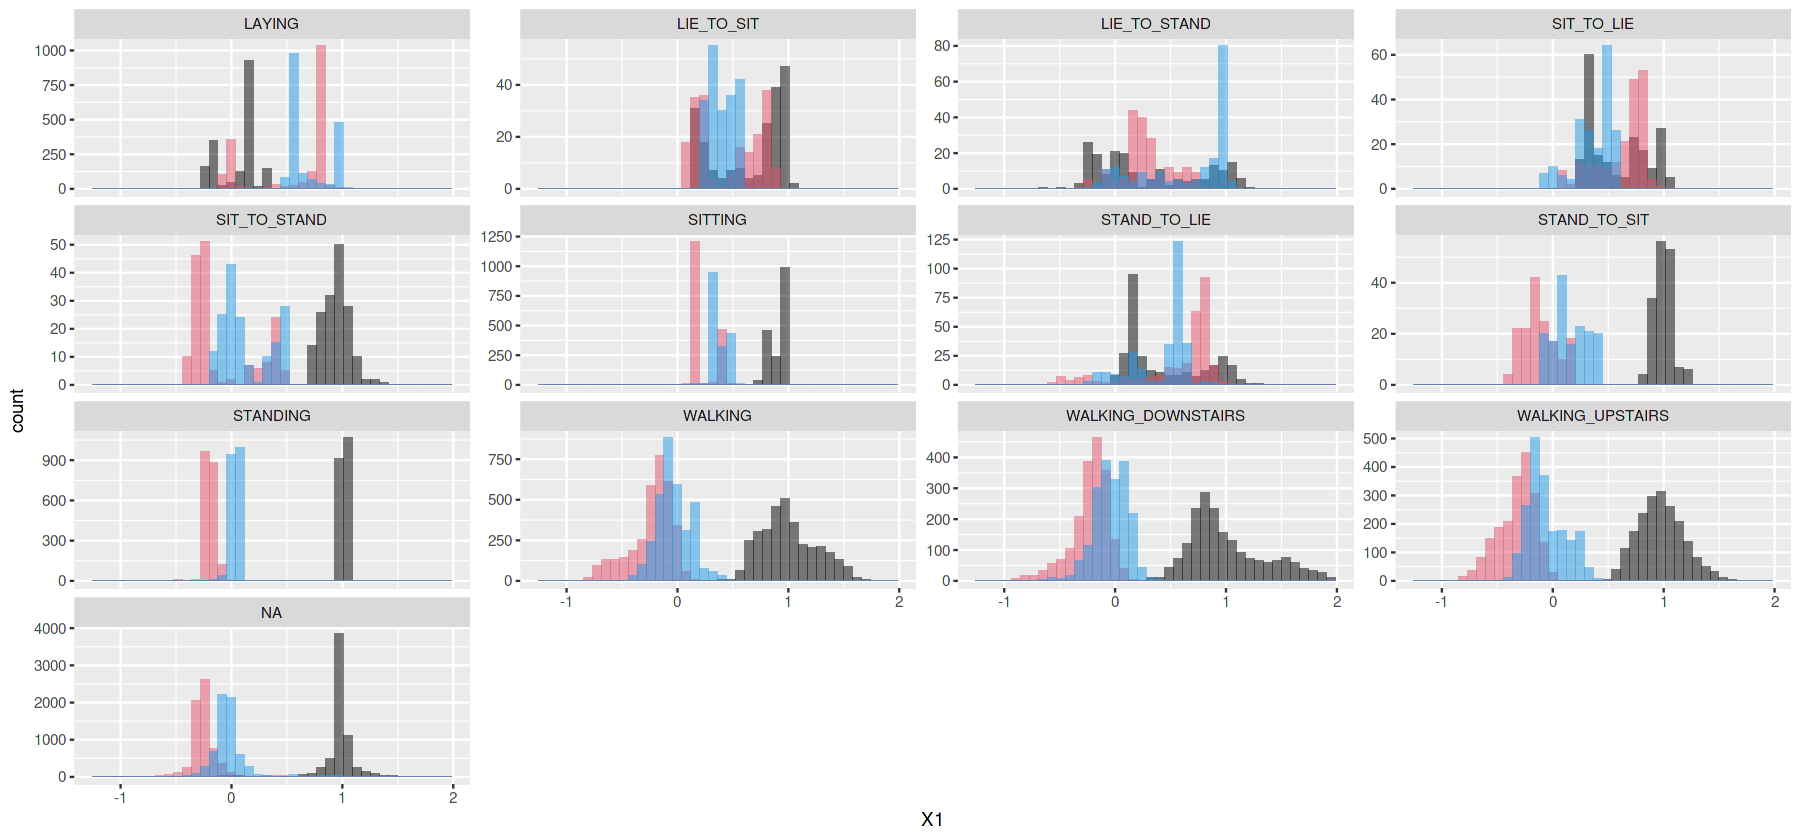

In [14]:
user_df %>%
    ggplot(aes(X1)) + 
      geom_histogram(bins=40, fill=1, alpha=0.5) + 
      geom_histogram(aes(X2), bins=40, fill = 2, alpha=0.5) + 
      geom_histogram(aes(X3), bins=40, fill = 4, alpha=0.5) +
      facet_wrap(~activity, scales = "free_y")

The histograms are quite distinct, and we can compute all kinds of statistics for them that characterize their shapes (e.g., mean, sd, skewness, inter-quartile ranges, etc.). Hence, useful features may be found amongst these statstical descriptive measures.

# Epochs

Now there's one other thing concerning these signals: The signals have different activities at different times, and in general, we don't know when an activity is going to start or end. 

In the Test data set you will be asked to predict the activities in subsequent time windows, called _epochs_, of 128 samples (=128 / 50Hz = 2.56 sec). So we will also train the algorithm on the signals that are segmented into _epochs_ of 128 samples.

To do so, we use a clever trick involving integer division: By dividing the sample number by 128 we obtain an integer that will group samples into epochs. For instance say we have sample numbers 0, 2, 3, ..., 14, and we want to group them into 4 epochs of length 3, then integer division yields:

In [15]:
0:14 %/% 3

[1] 0 0 0 1 1 1 2 2 2 3 3 3 4 4 4

We use this trick to group the rows in `user` into epochs, and then compute summary statistics per epoch. The result is a data frame with as many rows as there are epochs, and on each row the summary statistics computed. 

# Features extraction from signals

When we are looking at the statistical features, we look at the probability that certain values occur in the signal. A great technique for this, are histograms, because it converts signals into more understandable measurements. Therefore, statistical analyses can be performed and are quite better to understand what kind of data is received to draw conclusions from. Hence, we used a lot of histogram based features. The features that we used are mostly the standard statistical features derived from histograms (Signal processing, 2021).

The power of a signal is used for the energy per unit time.
Defining the energy of a signal is important, because it is a measure of signal strength. One can imagine if the signal strength is higher, more or faster movements are made by the person in the experiment.  (Power and Energy of a Signal: Demystified, Mathuranathan, 2013)

Autoregression coefficients is very useful in analyzing signals. This regression strategy uses the values of previous time steps to predict the next time steps. This is a really good way to predict the next signal “movements” in our model. (Autoregression Models for Time Series Forecasting With Python, Jason Brownlee, 2017)

After reviewing some literature, we found an article that states that cosine similarity scoring has been applied successfully before in speaker detection decision (Cosine Similarity Scoring without Score Normalization Techniques, Dehak et al). Because we are trying signal analysis, we used the cosine angle, since it was proven to be successful.


# Statistical features

** Histogram based features **
* Mean
* Median
* Mode 
* Minimum
* Maximum
* Skewness
* Entropy
* 25th quartile
* 75th quartile
* Standard Deviation
* Skewness
* Kurtosis
* Mean Absolute Deviation
* Standard Error

** Other statistical features **
* Variance
* Power: represents the average squared amplitude of the signal
* Energy

# Time domain features

Autoregression coefficients is very useful in analyzing signals. This regression strategy uses the values of previous time steps to predict the next time steps. This is a really good way to predict the next signal “movements” in our model. Because slowly changing signals have high autocorellations and fast changing signals have low or even negative autocorrelations we chose lags 1, 2 and 10 (Grasman, n.d.).

* Autoregression coefficient
* Cosine angle
* Correlation

In [16]:
# Helper function
most_common_value = function(x) {
    counts = table(x, useNA='no')
    most_frequent = which.max(counts)
    return(names(most_frequent))
}

# Feature function

In [17]:
lagged_cor = function(x, y = x, lag = 0) {
    # compute correlation between x and a time shifted y
    r_lagged = cor(x, dplyr::lag(y, lag), use = "pairwise")
   
    if(is.na(r_lagged)) {     
        return(0)
    } else{
        return(r_lagged)
    }
}

In [18]:
getMode <- function(x) {
  return(as.integer(which.max(table(x))))
}

In [19]:
stdError <- function(x) {
    return(sd(x) / sqrt(length(x)))
}

In [20]:
entropy <- function(x) {
    probs <- prop.table(table(x))
    return(-sum(probs * log2(probs)))
}

# code from: (Anten, Blankenstijn, & Nederrhoff ,2020, September 25)

# Feature functions we did not use

In [21]:
getautoreg <- function(y) {
    return(ar(rnorm(1000), aic = FALSE)$ar)
}

In [22]:
sbar <- function(x) {
  spec = spectrum(x, plot = F)
  df = spec$freq[2] - spec$freq[1]
  return(sum(spec$freq * spec$spec * df))
}

In [23]:
svar <- function(x) {
  spec = spectrum(x, plot = F)
  df = spec$freq[2] - spec$freq[1]
  sbar = sum(spec$freq * spec$spec * df)
  return(sum((spec$freq - sbar)^2 * spec$spec * df))
}

This is a tidy data frame that can be used in the classification algorithms discussed in chapters 3 and 4 of ISLR.

*Note You may not be familiar with the `AR1.1`, `AR1.2` and `AR12.1` computed above. These are called _autocorrelations_ (at lags 1 and 2) and _lagged cross-correlations_. They are discussed in [Feature Extraction from Signals](https://paper.dropbox.com/doc/Feature-extraction-from-Signals--A62tmtXDMS34X292NP0fKphQAQ-qCp5uvj47gmyuw5nmB8lL). They are interesting because slowly changing signals have high autocorellations, while fast changing signals have low or even negative autocorrelations.*

# 3. Putting it all together

Function that takes a data file name and calculates the features. The output is a data frame. We had a lot of help considering and searching for features using the document of Raoul from 2018 (Feature Extraction From Signals). Also, we looked at the codes used in the practical Voice Gender Recognition.

In [24]:
extractTimeDomainFeatures <- function(filename, sample_labels) {
    
    # extract user and experimental run ID's from file name
    username = gsub(".+user(\\d+).+", "\\1", filename) %>% as.numeric()
    expname  = gsub( ".+exp(\\d+).+", "\\1", filename) %>% as.numeric()
    
    # import the sensor signals from the file
    user01 <- read_delim(filename, " ", col_names = F, progress = TRUE, 
                 col_types = "ddd")
    
    
    # merge signals with labels 
    user_df <- 
        data.frame(userid = username, trial = expname, user01) %>%
        mutate(sampleid = 0:(nrow(user01)-1) ) %>%
        left_join(sample_labels, by = c('userid','trial','sampleid')) 

    
    # split in epochs of 128 samples and compute features per epoch
    usertimedom <-  user_df %>%
    
          # add an epoch ID variable (on epoch = 2.56 sec)
          mutate(epoch = sampleid %/% 128) %>% 

          # extract statistical features from each epoch
          group_by(epoch) %>%
          summarise(
            # keep track of user and experiment information
            user_id = username, 
            exp_id = expname,   
              
            # epoch's activity labels and start sample
            activity = most_common_value(c("-", activity)),
            sampleid = sampleid[1],
              
            ### Features ###
              
            mean1 = mean(X1), 
            mean2 = mean(X2),
            mean3 = mean(X3),
           
            median1 = median(X1), 
            median2 = median(X2),
            median3 = median(X3),
            
            mode1 = getMode(X1), 
            mode2 = getMode(X2),
            mode3 = getMode(X3),
              
            min1 = min(X1),
            min2 = min(X2),
            min3 = min(X3),
              
            max1 = max(X1),
            max3 = max(X2),
            max3 = max(X3),
              
            sd1 = sd(X1), 
            sd2 = sd(X2), 
            sd3 = sd(X3),
              
            skew1 = e1071::skewness(X1),
            skew2 = e1071::skewness(X2),
            skew3 = e1071::skewness(X3),
              
            var1 = var(X1),
            var2 = var(X2),
            var3 = var(X3),
              
            kurtosis1 = e1071::kurtosis(X1),
            kurtosis2 = e1071::kurtosis(X2),
            kurtosis3 = e1071::kurtosis(X3),
              
            mad1 = mad(X1), 
            mad2 = mad(X2),   
            mad3 = mad(X3),
            
            stdError1 = stdError(X1),  
            stdError2 = stdError(X2),
            stdError3 = stdError(X3),
              
            ### Other ###
            q1_25_1 = quantile(X1, .25),
            q1_25_2 = quantile(X2, .25),
            q1_25_3 = quantile(X3, .25),
              
            q3_75_1 = quantile(X1, .75),
            q3_75_2 = quantile(X2, .75),
            q3_75_3 = quantile(X3, .75),
    
            power1 = mean(X1^2),
            power2 = mean(X2^2),
            power3 = mean(X3^2),
              
            entropy1 = entropy(X1), 
            entropy2 = entropy(X2),
            entropy3 = entropy(X3),
              
            cor1_2 = cor(X1, X2),
            cor1_3 = cor(X1, X3), 
            cor2_3 = cor(X2, X3),
              
            cosangle1 = X1 %*% X2 / sqrt(sum(X1^2) * sum(X2^2)), 
            cosangle2 = X1 %*% X3 / sqrt(sum(X1^2) * sum(X3^2)),  
            cosangle3 = X3 %*% X2 / sqrt(sum(X3^2) * sum(X2^2)), 
              
            # inspiration to add lag 2 & 10 from Group 5  
            AR1_1 = lagged_cor(X1, lag = 1),            
            AR2_1 = lagged_cor(X2, lag = 1), 
            AR3_1 = lagged_cor(X3, lag = 1),
            AR1_2 = lagged_cor(X1, lag = 2),            
            AR2_2 = lagged_cor(X2, lag = 2), 
            AR3_2 = lagged_cor(X3, lag = 2),
            AR1_10 = lagged_cor(X1, lag = 10),       
            AR2_10 = lagged_cor(X2, lag = 10), 
            AR3_10 = lagged_cor(X3, lag = 10),
            AR12_1 = lagged_cor(X1, X2, lag = 1),
            AR13_1 = lagged_cor(X1, X3, lag = 1),
            AR23_1 = lagged_cor(X2, X3, lag = 1),
            AR12_2 = lagged_cor(X1, X2, lag = 2),
            AR13_2 = lagged_cor(X1, X3, lag = 2),
            AR23_2 = lagged_cor(X2, X3, lag = 2),
            AR12_10 = lagged_cor(X1, X2, lag = 10),
            AR13_10 = lagged_cor(X1, X3, lag = 10),
            AR23_10 = lagged_cor(X2, X3, lag = 10),
              
              
            ### lda Warning: “variables are collinear” ###
              
            #energy1 = sum(power1),
            #energy2 = sum(power2),
            #energy3 = sum(power3),
              
            #range1 = max(X1) - min(X1), 
            #range2 = max(X2) - min(X2),
            #range3 = max(X3) - min(X3),
              
            #IQR1 = q1_25_1 - q3_75_1,  
            #IQR2 = q1_25_2 - q3_75_2,
            #IQR3 = q1_25_3 - q3_75_3,
              
            ### features we did not use ###
              
            #fft1 = fft(X1, inverse = FALSE), # does not work: notebook tried to allocate more 
            #fft2 = fft(X2, inverse = FALSE), # memory than available
            #fft3 = fft(X3, inverse = FALSE),
    
              
            n_samples = n()
          ) 
    
    usertimedom 
}

# Get Training Data

Because there was information about two kind of sensors, we made two training data sets: one for the accelerometer and one for the gyrometer. We merged the two sets using the dplyr package, to get or final training data.

In [25]:
filenames_acc <- dir("./RawData/Train/", "^acc", full.names = TRUE) 
train_acc = map_dfr(filenames_acc, extractTimeDomainFeatures, 
                         sample_labels) 

filenames_gyro <- dir("./RawData/Train/", "^gyro", full.names = TRUE) 
train_gyro = map_dfr(filenames_gyro, extractTimeDomainFeatures, sample_labels) 

# Merging acc and gyro data frame
trainData <- train_acc %>%
    left_join(train_gyro, suffix = c("_acc", "_gyro"), 
              by = c("epoch", "user_id", "exp_id", "activity", 
                     "sampleid", "n_samples"))

head(trainData)

epoch,user_id,exp_id,activity,sampleid,mean1_acc,mean2_acc,mean3_acc,median1_acc,median2_acc,⋯,AR3_10_gyro,AR12_1_gyro,AR13_1_gyro,AR23_1_gyro,AR12_2_gyro,AR13_2_gyro,AR23_2_gyro,AR12_10_gyro,AR13_10_gyro,AR23_10_gyro
<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1,1,-,0,0.908941,-0.1649089,0.25218100,0.862500,-0.1437500,⋯,-0.15361065,0.40172273,-0.11561293,0.09209496,0.17218225,-0.22197453,-0.11372002,0.09323773,0.050157393,-0.02834603
1,1,1,STANDING,128,1.015723,-0.1324110,0.05088976,1.020833,-0.1277778,⋯,-0.15803073,-0.06176686,0.13260638,0.03089586,-0.12006322,0.13730611,0.09487645,-0.07682900,0.023906578,0.15112032
2,1,1,STANDING,256,1.019217,-0.1241102,0.09873047,1.019445,-0.1250000,⋯,-0.04157380,0.01317126,-0.14471552,-0.22996855,-0.05474171,-0.17155637,-0.05848529,0.21588363,-0.324764907,0.13875873
3,1,1,STANDING,384,1.020074,-0.1254232,0.09264323,1.020833,-0.1263889,⋯,-0.12950006,-0.09806813,-0.05906356,-0.18889117,-0.13311944,-0.08846585,-0.11095641,-0.05605294,-0.507133222,0.18222178
4,1,1,STANDING,512,1.020172,-0.1297960,0.08509115,1.019445,-0.1305556,⋯,-0.09533106,-0.35076721,0.57796574,-0.54557782,-0.44116102,0.66796940,-0.52476250,0.02288813,0.234063304,0.14631200
5,1,1,STANDING,640,1.020757,-0.1285590,0.08496094,1.020833,-0.1277778,⋯,0.14903578,-0.05752755,0.48180132,-0.57829621,-0.08452439,0.43673795,-0.52048635,-0.16207393,0.003771471,-0.39612405


We did not want any NA's in our training data as this would cause problems when running the functions below.

In [26]:
stopifnot(!is.na(trainData))

In [27]:
train_data_all_predictors <- trainData %>%
  select(-epoch, -user_id, -exp_id, -sampleid, -n_samples)

head(train_data_all_predictors, 2)

activity,mean1_acc,mean2_acc,mean3_acc,median1_acc,median2_acc,median3_acc,mode1_acc,mode2_acc,mode3_acc,⋯,AR3_10_gyro,AR12_1_gyro,AR13_1_gyro,AR23_1_gyro,AR12_2_gyro,AR13_2_gyro,AR23_2_gyro,AR12_10_gyro,AR13_10_gyro,AR23_10_gyro
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-,0.908941,-0.1649089,0.25218100,0.862500,-0.1437500,0.50347224,37,19,81,⋯,-0.1536107,0.40172273,-0.1156129,0.09209496,0.1721823,-0.2219745,-0.11372002,0.09323773,0.05015739,-0.02834603
STANDING,1.015723,-0.1324110,0.05088976,1.020833,-0.1277778,0.08194444,41,40,51,⋯,-0.1580307,-0.06176686,0.1326064,0.03089586,-0.1200632,0.1373061,0.09487645,-0.07682900,0.02390658,0.15112032


# Check for Near Zero Variation

Predictors with near zero variation can cause unstable models. That is why we wrote a code to check whether this kind of predictors are present in our dataset. Fortunately, this was not the case.

In [28]:
getNearZeroVariationPredictors <- function(train_df) {
  
  nzv_predictors <- train_df %>%
    select(-epoch, -user_id, -exp_id, -sampleid, -n_samples, -activity) %>%
    nearZeroVar(names = TRUE)
  
  if(length(nzv_predictors) == 0) {
    
    return(0L)  
    
  } else {
    
    return(nzv_predictors)
  }
}

getNearZeroVariationPredictors(trainData)

[1] 0

# Check for Highly Correlated Variables

Predictors that are highly correlated will only increase the complexity of the model, instead of adding extra information. We want this 'noise' out of our dataset, to make sure we are not overfitting our model on our training data. Therefore, we excluded the predictors with high correlation out of the training data. 47 predictors had a high correlation.

In [29]:
getHighCorPredictors <- function(train_df) {
  
  high_cor_predictors <- train_df %>% 
    select(-epoch, -user_id, -exp_id, -sampleid, -n_samples, -activity) %>%
    cor() %>%
    findCorrelation(.9, names = TRUE)
  
  return(high_cor_predictors)
}

getHighCorPredictors(trainData)

[1] "stdError1_acc"  "stdError2_acc"  "q1_25_2_acc"    "q1_25_3_acc"   
 [5] "q3_75_1_acc"    "q3_75_3_acc"    "power1_acc"     "entropy2_acc"  
 [9] "entropy3_acc"   "AR13_1_acc"     "AR13_2_acc"     "power2_gyro"   
[13] "power3_gyro"    "entropy3_gyro"  "cosangle1_gyro" "cosangle3_gyro"
[17] "AR13_1_gyro"    "AR23_1_gyro"    "AR12_2_gyro"    "AR13_2_gyro"   
[21] "AR23_2_gyro"    "mean1_acc"      "mean2_acc"      "mean3_acc"     
[25] "sd1_acc"        "sd2_acc"        "sd3_acc"        "median1_acc"   
[29] "min1_acc"       "min2_acc"       "min3_acc"       "median2_acc"   
[33] "median3_acc"    "AR1_1_acc"      "AR3_1_acc"      "cor1_2_acc"    
[37] "cor2_3_acc"     "AR12_1_acc"     "AR23_1_acc"     "mean1_gyro"    
[41] "sd1_gyro"       "sd2_gyro"       "sd3_gyro"       "var1_gyro"     
[45] "entropy1_gyro"  "cor1_3_gyro"    "cor1_2_gyro"

In [30]:
clean_train_data1 <- trainData %>%
  select(-getNearZeroVariationPredictors(trainData), - getHighCorPredictors(trainData),
         -epoch, -user_id, -exp_id, -sampleid, -n_samples)


head(clean_train_data1, 2)

activity,mode1_acc,mode2_acc,mode3_acc,max1_acc,max3_acc,skew1_acc,skew2_acc,skew3_acc,var1_acc,⋯,AR1_2_gyro,AR2_2_gyro,AR3_2_gyro,AR1_10_gyro,AR2_10_gyro,AR3_10_gyro,AR12_1_gyro,AR12_10_gyro,AR13_10_gyro,AR23_10_gyro
<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-,37,19,81,1.613889,0.7291667,2.0050324,-1.00890982,-0.5132241,0.021559669,⋯,0.3393349,0.4912874,0.1651209,0.08945982,0.3699443,-0.1536107,0.40172273,0.09323773,0.05015739,-0.02834603
STANDING,41,40,51,1.265278,0.3472222,-0.0756085,-0.03534337,-1.6324974,0.006771014,⋯,0.2851802,0.1016244,0.6516881,-0.12899381,-0.2444625,-0.1580307,-0.06176686,-0.07682900,0.02390658,0.15112032


# Check for Multicollinearity

Multicollinearity will have an influence on predicting the coefficients for the predictors. 

In [31]:
vif_df <- clean_train_data1 %>%
    mutate(activity = as.factor(activity)) 

fit_vif = lm(as.numeric(activity) ~ ., data = vif_df)

multicollinear_predictors <- car::vif(fit_vif) %>%
    as.data.frame() %>%
    filter(. >= 10) %>%
    rownames()

multicollinear_predictors

[1] "max1_acc"       "var1_acc"       "var3_acc"       "mad1_acc"      
 [5] "stdError3_acc"  "q1_25_1_acc"    "q3_75_2_acc"    "power2_acc"    
 [9] "power3_acc"     "entropy1_acc"   "AR2_1_acc"      "AR2_2_acc"     
[13] "mean2_gyro"     "mean3_gyro"     "min1_gyro"      "min2_gyro"     
[17] "min3_gyro"      "max1_gyro"      "max3_gyro"      "var2_gyro"     
[21] "var3_gyro"      "mad1_gyro"      "mad2_gyro"      "mad3_gyro"     
[25] "stdError1_gyro" "stdError2_gyro" "stdError3_gyro" "q1_25_1_gyro"  
[29] "q1_25_2_gyro"   "q1_25_3_gyro"   "q3_75_1_gyro"   "q3_75_2_gyro"  
[33] "q3_75_3_gyro"   "power1_gyro"    "entropy2_gyro"  "AR1_1_gyro"    
[37] "AR2_1_gyro"     "AR3_1_gyro"     "AR1_2_gyro"     "AR3_2_gyro"

In [32]:
clean_train_data2 <- clean_train_data1 %>%
    select(-all_of(multicollinear_predictors))

head(clean_train_data2)

activity,mode1_acc,mode2_acc,mode3_acc,max3_acc,skew1_acc,skew2_acc,skew3_acc,var2_acc,kurtosis1_acc,⋯,cor2_3_gyro,cosangle2_gyro,AR2_2_gyro,AR1_10_gyro,AR2_10_gyro,AR3_10_gyro,AR12_1_gyro,AR12_10_gyro,AR13_10_gyro,AR23_10_gyro
<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,"<dbl[,1]>",<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-,37,19,81,0.7291667,2.00503237,-1.00890982,-0.51322409,6.712583e-03,6.7388521,⋯,0.2127891,0.12465094,0.4912874,0.08945982,0.36994435,-0.15361065,0.40172273,0.09323773,0.050157393,-0.02834603
STANDING,41,40,51,0.3472222,-0.07560850,-0.03534337,-1.63249742,2.409512e-03,1.5460273,⋯,0.1401862,0.23092866,0.1016244,-0.12899381,-0.24446251,-0.15803073,-0.06176686,-0.07682900,0.023906578,0.15112032
STANDING,6,11,14,0.1097222,0.01030481,-0.16029915,-0.95896747,1.521138e-05,0.6269858,⋯,-0.3943527,0.06151575,0.1228630,0.19402052,-0.05485760,-0.04157380,0.01317126,0.21588363,-0.324764907,0.13875873
STANDING,7,6,15,0.1097222,-0.37654877,0.42325422,0.03989466,4.886504e-05,0.7756232,⋯,-0.2629211,0.13905539,0.2858459,0.31678615,-0.20989763,-0.12950006,-0.09806813,-0.05605294,-0.507133222,0.18222178
STANDING,6,8,12,0.1013889,-0.28076432,0.07004263,-0.18641594,2.402485e-05,-0.1064957,⋯,-0.5871183,0.45059695,0.4175869,0.18926511,-0.07299978,-0.09533106,-0.35076721,0.02288813,0.234063304,0.14631200
STANDING,7,20,10,0.1041667,-0.03199556,-0.97726258,-0.20119510,6.232838e-05,-0.1674791,⋯,-0.6103359,0.47933572,0.6653331,0.11088430,0.30961350,0.14903578,-0.05752755,-0.16207393,0.003771471,-0.39612405


Now the data are turned into a tidy format with features that can be used in any of the algorithms. 


# 4. Model fitting

Cross validation is performed to train the models and assessing whether it is under- or overfitted. We used K=10, because it has a higher variance and therefore a lower bias. For a lower K, more bias is introduced.

In [33]:
# Cross validation
trcntr = trainControl("cv", number = 10, p = 0.8)

# Linear Discriminant Analysis

We used the LDA fitting for the train data with all the predictors and the cleaned data (predictors with high correlation removed). 

In [34]:
fit_lda_all_cv = train(activity ~ ., dat = train_data_all_predictors, method = "lda", trControl = trcntr)
fit_lda_all_cv

Linear Discriminant Analysis 

6252 samples
 136 predictor
  13 classes: '-', 'LAYING', 'LIE_TO_SIT', 'LIE_TO_STAND', 'SIT_TO_LIE', 'SIT_TO_STAND', 'SITTING', 'STAND_TO_LIE', 'STAND_TO_SIT', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 5628, 5628, 5626, 5628, 5630, 5623, ... 
Resampling results:

  Accuracy   Kappa    
  0.8349252  0.8097446


In [35]:
fit_lda_cv = train(activity ~ ., dat = clean_train_data1, method = "lda", trControl = trcntr)
fit_lda_cv

Linear Discriminant Analysis 

6252 samples
  89 predictor
  13 classes: '-', 'LAYING', 'LIE_TO_SIT', 'LIE_TO_STAND', 'SIT_TO_LIE', 'SIT_TO_STAND', 'SITTING', 'STAND_TO_LIE', 'STAND_TO_SIT', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 5627, 5625, 5626, 5626, 5625, 5628, ... 
Resampling results:

  Accuracy   Kappa    
  0.8173381  0.7895272


# Quadratic discriminant analysis
We also tried QDA with stepwise regression, to assess if it is a better method than LDA. 

In [36]:
fit_qda_cv = train(activity ~ ., dat = clean_train_data1, method = "stepQDA", trControl = trcntr)
fit_qda_cv

 `stepwise classification', using 10-fold cross-validated correctness rate of method qda'.

5625 observations of 89 variables in 13 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.50614;  in: "max1_acc";  variables (1): max1_acc 
correctness rate: 0.59466;  in: "cosangle1_acc";  variables (2): max1_acc, cosangle1_acc 
correctness rate: 0.65903;  in: "q1_25_1_gyro";  variables (3): max1_acc, cosangle1_acc, q1_25_1_gyro 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        1.00       30.37 



 `stepwise classification', using 10-fold cross-validated correctness rate of method qda'.

5628 observations of 89 variables in 13 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.50302;  in: "max1_acc";  variables (1): max1_acc 
correctness rate: 0.59612;  in: "q3_75_2_acc";  variables (2): max1_acc, q3_75_2_acc 
correctness rate: 0.67341;  in: "q1_25_1_gyro";  variables (3): max1_acc, q3_75_2_acc, q1_25_1_gyro 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       1.000      30.066 



 `stepwise classification', using 10-fold cross-validated correctness rate of method qda'.

5627 observations of 89 variables in 13 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.50578;  in: "max1_acc";  variables (1): max1_acc 
correctness rate: 0.59517;  in: "cosangle1_acc";  variables (2): max1_acc, cosangle1_acc 
correctness rate: 0.65771;  in: "q1_25_1_gyro";  variables (3): max1_acc, cosangle1_acc, q1_25_1_gyro 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       1.000      29.988 



 `stepwise classification', using 10-fold cross-validated correctness rate of method qda'.

5626 observations of 89 variables in 13 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.50497;  in: "max1_acc";  variables (1): max1_acc 
correctness rate: 0.59367;  in: "q3_75_2_acc";  variables (2): max1_acc, q3_75_2_acc 
correctness rate: 0.67027;  in: "q1_25_1_gyro";  variables (3): max1_acc, q3_75_2_acc, q1_25_1_gyro 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       1.000      28.949 



 `stepwise classification', using 10-fold cross-validated correctness rate of method qda'.

5625 observations of 89 variables in 13 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.50453;  in: "max1_acc";  variables (1): max1_acc 
correctness rate: 0.59378;  in: "q3_75_2_acc";  variables (2): max1_acc, q3_75_2_acc 
correctness rate: 0.66489;  in: "min1_gyro";  variables (3): max1_acc, q3_75_2_acc, min1_gyro 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       1.000      29.077 



 `stepwise classification', using 10-fold cross-validated correctness rate of method qda'.

5626 observations of 89 variables in 13 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.50604;  in: "max1_acc";  variables (1): max1_acc 
correctness rate: 0.59331;  in: "cosangle1_acc";  variables (2): max1_acc, cosangle1_acc 
correctness rate: 0.65499;  in: "q1_25_1_gyro";  variables (3): max1_acc, cosangle1_acc, q1_25_1_gyro 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       1.000      30.661 



 `stepwise classification', using 10-fold cross-validated correctness rate of method qda'.

5627 observations of 89 variables in 13 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.50631;  in: "max1_acc";  variables (1): max1_acc 
correctness rate: 0.59498;  in: "cosangle1_acc";  variables (2): max1_acc, cosangle1_acc 
correctness rate: 0.65772;  in: "q1_25_1_gyro";  variables (3): max1_acc, cosangle1_acc, q1_25_1_gyro 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       1.000      29.806 



 `stepwise classification', using 10-fold cross-validated correctness rate of method qda'.

5627 observations of 89 variables in 13 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.5072;  in: "max1_acc";  variables (1): max1_acc 
correctness rate: 0.59392;  in: "q3_75_2_acc";  variables (2): max1_acc, q3_75_2_acc 
correctness rate: 0.66944;  in: "q1_25_1_gyro";  variables (3): max1_acc, q3_75_2_acc, q1_25_1_gyro 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       1.000      29.896 



 `stepwise classification', using 10-fold cross-validated correctness rate of method qda'.

5627 observations of 89 variables in 13 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.5104;  in: "max1_acc";  variables (1): max1_acc 
correctness rate: 0.59623;  in: "cosangle1_acc";  variables (2): max1_acc, cosangle1_acc 
correctness rate: 0.6556;  in: "q1_25_1_gyro";  variables (3): max1_acc, cosangle1_acc, q1_25_1_gyro 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        1.00       29.32 



 `stepwise classification', using 10-fold cross-validated correctness rate of method qda'.

5630 observations of 89 variables in 13 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.50426;  in: "max1_acc";  variables (1): max1_acc 
correctness rate: 0.59165;  in: "q3_75_2_acc";  variables (2): max1_acc, q3_75_2_acc 
correctness rate: 0.66874;  in: "q1_25_1_gyro";  variables (3): max1_acc, q3_75_2_acc, q1_25_1_gyro 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       1.000      28.764 



 `stepwise classification', using 10-fold cross-validated correctness rate of method qda'.

6252 observations of 89 variables in 13 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.50608;  in: "max1_acc";  variables (1): max1_acc 
correctness rate: 0.59597;  in: "q3_75_2_acc";  variables (2): max1_acc, q3_75_2_acc 
correctness rate: 0.67099;  in: "q1_25_1_gyro";  variables (3): max1_acc, q3_75_2_acc, q1_25_1_gyro 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       1.000      37.005 



Quadratic Discriminant Analysis with Stepwise Feature Selection 

6252 samples
  89 predictor
  13 classes: '-', 'LAYING', 'LIE_TO_SIT', 'LIE_TO_STAND', 'SIT_TO_LIE', 'SIT_TO_STAND', 'SITTING', 'STAND_TO_LIE', 'STAND_TO_SIT', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 5625, 5628, 5627, 5626, 5625, 5626, ... 
Resampling results:

  Accuracy   Kappa    
  0.6637989  0.6155415

Tuning parameter 'maxvar' was held constant at a value of Inf
Tuning
 parameter 'direction' was held constant at a value of both

# k-nearest neighbors

In [37]:
fit_knn_cv = train(activity ~ ., data = clean_train_data1, method = "knn", trControl = trcntr, preProcess = "scale")
fit_knn_cv

k-Nearest Neighbors 

6252 samples
  89 predictor
  13 classes: '-', 'LAYING', 'LIE_TO_SIT', 'LIE_TO_STAND', 'SIT_TO_LIE', 'SIT_TO_STAND', 'SITTING', 'STAND_TO_LIE', 'STAND_TO_SIT', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS' 

Pre-processing: scaled (89) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 5627, 5625, 5627, 5627, 5628, 5626, ... 
Resampling results across tuning parameters:

  k  Accuracy   Kappa    
  5  0.8283847  0.8020212
  7  0.8267928  0.8001078
  9  0.8282313  0.8017412

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 5.

# Multinomial logistic regression

For Multinomial logistic regression there should be no multicollinearity, therefore, we choose the train data where predictors with NZV, high correlation and a Variance inflation factor higher than 10 are removed.


In [38]:
fit_multi_cv = train(activity ~ ., data = clean_train_data2, method = "multinom", trControl = trcntr)
fit_multi_cv

# weights:  663 (600 variable)
initial  value 14438.099933 
iter  10 value 11000.928110
iter  20 value 9812.334508
iter  30 value 9025.690034
iter  40 value 8092.400669
iter  50 value 7478.098617
iter  60 value 6726.000402
iter  70 value 6343.849681
iter  80 value 5983.263537
iter  90 value 5712.156358
iter 100 value 5311.934761
final  value 5311.934761 
stopped after 100 iterations
# weights:  663 (600 variable)
initial  value 14438.099933 
iter  10 value 11000.932263
iter  20 value 9812.472114
iter  30 value 9026.268256
iter  40 value 8093.674754
iter  50 value 7483.092109
iter  60 value 6755.995212
iter  70 value 6286.197834
iter  80 value 5923.476153
iter  90 value 5701.120632
iter 100 value 5357.542846
final  value 5357.542846 
stopped after 100 iterations
# weights:  663 (600 variable)
initial  value 14438.099933 
iter  10 value 11000.928114
iter  20 value 9812.334646
iter  30 value 9025.690611
iter  40 value 8092.401924
iter  50 value 7478.103104
iter  60 value 6726.047391
iter 

Penalized Multinomial Regression 

6252 samples
  49 predictor
  13 classes: '-', 'LAYING', 'LIE_TO_SIT', 'LIE_TO_STAND', 'SIT_TO_LIE', 'SIT_TO_STAND', 'SITTING', 'STAND_TO_LIE', 'STAND_TO_SIT', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 5629, 5629, 5627, 5629, 5625, 5625, ... 
Resampling results across tuning parameters:

  decay  Accuracy   Kappa    
  0e+00  0.6819980  0.6346771
  1e-04  0.6815191  0.6342150
  1e-01  0.6824757  0.6352952

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was decay = 0.1.

# Model performance

To visualize which model is performing the best, we used codes from the Voice Gender Recognition to assess the performance. Barplots are made using the accuracy of each model, to get a clear visualization. Looking at the barchart below, we see that LDA with all the predictors has the highest accuracy. That is why we are using the model with LDA as method and all predictors to predict the labels for our test data.

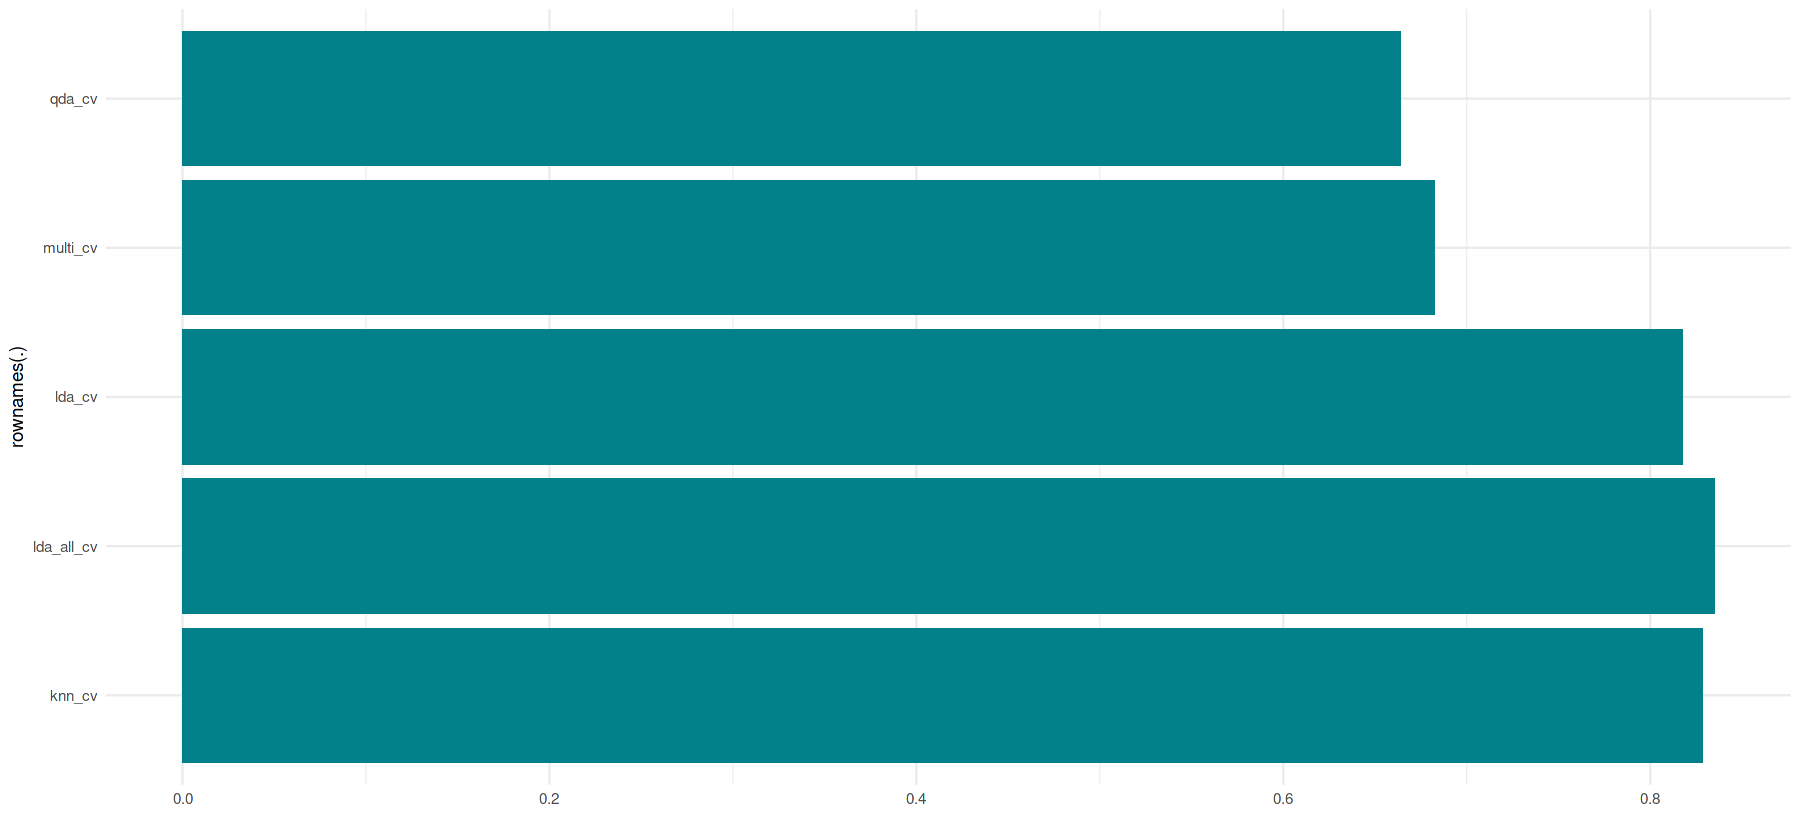

In [39]:
models <- list(lda_all_cv = fit_lda_all_cv, lda_cv = fit_lda_cv, 
               qda_cv = fit_qda_cv, knn_cv = fit_knn_cv, multi_cv = fit_multi_cv)

accuracy_models <- models %>%
    sapply(FUN = function(mdl) {max(mdl$results$Accuracy)}) %>%
    data.frame(accuracy = ., row.names = c("lda_all_cv", "lda_cv", "qda_cv", "knn_cv", "multi_cv")) %>%
    ggplot(aes(x = rownames(.), y = accuracy)) +
    geom_bar(stat = "identity", fill = "#02818a") +
    ylab("") +
    coord_flip() +
    theme_minimal()

accuracy_models

There is a presumption our KNNS model is overfitting, if we look at the leaderboard. If you train a model extensively on your training dataset, the error will decrease until it is almost zero. The model is now perfectly fit on the training data. However, we believe that this model is overfitted, which means the error of the model in the test data is increasing. This has to do with the bias-variance tradeoff. One wants more variance in the model, but has the risk it will introduce bias, due to overfitting (Sing, 2018).  There is an optimal window, where the error rate in the training phase is as low as possible, without overfitting the model (Lecture 12, n.d.). 

# Get Test Data

The test data is imported in the same way as the training data.

In [40]:
filenames_test_acc <- dir("./RawData/Test/", "^acc", full.names = TRUE) 
test_acc = map_dfr(filenames_test_acc, extractTimeDomainFeatures, 
                         sample_labels) 

filenames_test_gyro <- dir("./RawData/Test/", "^gyro", full.names = TRUE)
test_gyro = map_dfr(filenames_test_gyro, extractTimeDomainFeatures, sample_labels) 

# Merging
test_data <- test_acc %>%
    left_join(test_gyro, suffix = c("_acc", "_gyro"), 
              by = c("epoch", "exp_id", "user_id", "activity", 
                     "sampleid", "n_samples"))

head(test_data)

Warning message in cor(x, dplyr::lag(y, lag), use = "pairwise"):
“the standard deviation is zero”
Warning message in cor(x, dplyr::lag(y, lag), use = "pairwise"):
“the standard deviation is zero”


epoch,user_id,exp_id,activity,sampleid,mean1_acc,mean2_acc,mean3_acc,median1_acc,median2_acc,⋯,AR3_10_gyro,AR12_1_gyro,AR13_1_gyro,AR23_1_gyro,AR12_2_gyro,AR13_2_gyro,AR23_2_gyro,AR12_10_gyro,AR13_10_gyro,AR23_10_gyro
<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2,3,-,0,0.1693034,-0.2382921,0.8003690,0.3736111,-0.09861112,⋯,0.42169335,0.43153210,-0.23695256,0.09333155,0.34154915,-0.25117043,0.02556732,0.201861858,-0.377825991,-0.22389895
1,2,3,-,128,0.8997071,-0.3948568,-0.2429905,0.9541667,-0.32222224,⋯,0.06421977,0.22386690,0.04157528,-0.04911401,0.12010533,0.02403006,-0.05374622,-0.119777357,0.009645524,0.12266001
2,2,3,-,256,0.9974935,-0.2712565,0.1135525,0.9972222,-0.26944447,⋯,-0.11953992,0.14112825,-0.03112331,-0.02607924,0.10348440,-0.12927020,-0.01962225,0.029028003,-0.221551172,-0.27250238
3,2,3,-,384,0.9928928,-0.2702691,0.1391276,0.9930556,-0.26944447,⋯,0.35610748,-0.46667093,0.58336889,-0.63443351,-0.45447166,0.62168376,-0.46446338,0.003135506,0.401617941,-0.40472583
4,2,3,-,512,0.9908854,-0.2861979,0.1286350,0.9909722,-0.28611112,⋯,-0.10070165,-0.57532263,0.52378889,-0.82850513,-0.55515676,0.50922767,-0.71975988,-0.109451268,0.162723700,0.09100783
5,2,3,-,640,0.9909180,-0.2904948,0.1215712,0.9902778,-0.28888890,⋯,-0.48443181,-0.02615859,0.03583592,-0.65877138,-0.04872595,0.05417842,-0.47435245,-0.022475382,-0.181547380,0.40576704


You should maybe think about the following issues
* What do you do with the unlabelled epochs? That is, the epochs that are marked with -?
* Should you remove the epochs that do not consist of 128 samples (i.e., n ≠ 128 in the above data frame)?

In [41]:
sort(unique(trainData$n_samples))
sort(unique(test_data$n_samples))

[1]   2  10  12  16  18  19  20  26  27  28  43  45  47  53  55  62  66  70  76
[20]  77  79  80  85  86  89  91  92  96  97  99 100 110 114 116 118 128

[1]   4   5   9  16  32  42  43  53  81  90  98 106 109 114 116 120 123 127 128

Our first idea was to remove the epochs in the test data that do not match the same sample sizes as in the test data (2, 10, 12, 18, 19, 20, 26, 27, 28, 45, 47, 55, 62, 66, 70, 76, 77, 79, 80, 85, 86, 89, 91, 92, 96, 97, 99, 100, 110, 118).
However, we decided not to remove the unlabeled epochs or epochs that do not have the same sample sizes because 1) the training data contains unlabeled epochs as well and 2) when applying our model to real world data it is better to not overfit on the test data.

# Predictions

The predict function was used to predict the activities performed during the signals in the test dataset. The best fitted model was used for predicting the activitites. In our notebook, the best method for fitting was ...., because this had the highest accuracy (0.8....)

In [42]:
# change to best model
pred_lda = predict(fit_lda_cv, new = test_data)
head(pred_lda, 40)

[1] -            -            -            STANDING     STANDING    
 [6] STANDING     STANDING     STANDING     STANDING     STANDING    
[11] STANDING     -            -            STANDING     STANDING    
[16] STANDING     STANDING     SITTING      STANDING     STANDING    
[21] SIT_TO_STAND STANDING     STANDING     STANDING     STANDING    
[26] -            STANDING     STANDING     STANDING     STANDING    
[31] -            STAND_TO_LIE STAND_TO_LIE LAYING       LAYING      
[36] LAYING       LAYING       LAYING       LAYING       LAYING      
13 Levels: - LAYING LIE_TO_SIT LIE_TO_STAND SIT_TO_LIE SIT_TO_STAND ... WALKING_UPSTAIRS

In [43]:
predictedData = test_data %>% mutate(activity = pred_lda)
head(predictedData)

epoch,user_id,exp_id,activity,sampleid,mean1_acc,mean2_acc,mean3_acc,median1_acc,median2_acc,⋯,AR3_10_gyro,AR12_1_gyro,AR13_1_gyro,AR23_1_gyro,AR12_2_gyro,AR13_2_gyro,AR23_2_gyro,AR12_10_gyro,AR13_10_gyro,AR23_10_gyro
<dbl>,<dbl>,<dbl>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2,3,-,0,0.1693034,-0.2382921,0.8003690,0.3736111,-0.09861112,⋯,0.42169335,0.43153210,-0.23695256,0.09333155,0.34154915,-0.25117043,0.02556732,0.201861858,-0.377825991,-0.22389895
1,2,3,-,128,0.8997071,-0.3948568,-0.2429905,0.9541667,-0.32222224,⋯,0.06421977,0.22386690,0.04157528,-0.04911401,0.12010533,0.02403006,-0.05374622,-0.119777357,0.009645524,0.12266001
2,2,3,-,256,0.9974935,-0.2712565,0.1135525,0.9972222,-0.26944447,⋯,-0.11953992,0.14112825,-0.03112331,-0.02607924,0.10348440,-0.12927020,-0.01962225,0.029028003,-0.221551172,-0.27250238
3,2,3,STANDING,384,0.9928928,-0.2702691,0.1391276,0.9930556,-0.26944447,⋯,0.35610748,-0.46667093,0.58336889,-0.63443351,-0.45447166,0.62168376,-0.46446338,0.003135506,0.401617941,-0.40472583
4,2,3,STANDING,512,0.9908854,-0.2861979,0.1286350,0.9909722,-0.28611112,⋯,-0.10070165,-0.57532263,0.52378889,-0.82850513,-0.55515676,0.50922767,-0.71975988,-0.109451268,0.162723700,0.09100783
5,2,3,STANDING,640,0.9909180,-0.2904948,0.1215712,0.9902778,-0.28888890,⋯,-0.48443181,-0.02615859,0.03583592,-0.65877138,-0.04872595,0.05417842,-0.47435245,-0.022475382,-0.181547380,0.40576704


# 5. Submissions

## Formatting the submission file

In [44]:
predictedData %>%

    # prepend "user" and "exp" to user_id and exp_id
    mutate(
        user_id = paste(ifelse(user_id < 10, "user0", "user"), user_id, sep=""), 
        exp_id = paste(ifelse(exp_id < 10, "exp0", "exp"), exp_id, sep="")
    ) %>% 

    # unit columnes user_id, exp_id and sample_id into a string 
    # separated by "_" and store it in the new variable `Id`
    unite(Id, user_id, exp_id, sampleid) %>%

    # retain only the `Id` and  predictions
    select(Id, Predicted = activity) %>%

    # write to file
    write_csv("test_set_predictions.csv")


# Check the result: print first 20 lines in the submission file
cat(readLines("test_set_predictions.csv",20), sep = "\n")

Id,Predicted
user02_exp03_0,-
user02_exp03_128,-
user02_exp03_256,-
user02_exp03_384,STANDING
user02_exp03_512,STANDING
user02_exp03_640,STANDING
user02_exp03_768,STANDING
user02_exp03_896,STANDING
user02_exp03_1024,STANDING
user02_exp03_1152,STANDING
user02_exp03_1280,STANDING
user02_exp03_1408,-
user02_exp03_1536,-
user02_exp03_1664,STANDING
user02_exp03_1792,STANDING
user02_exp03_1920,STANDING
user02_exp03_2048,STANDING
user02_exp03_2176,SITTING
user02_exp03_2304,STANDING


# Division of labour:

* Initial set up of the script: Ini, Mathilde Jessica
* Build of features: Jessica, Ini, Mathilde
* Description of features: Ini
* NZV, High correlations and multicollinearity: Jessica
* Build of model: Mathilde
* Model performance: Jessica
* Finalizing document: Mathilde, Jessica, Ini

# References

Anten, J., Blankenstijn, D., & Nederrhoff, A. (2020, September 25). Group 3: Physical activity recognition round 2. Kaggle: Your Machine Learning and Data Science Community. https://www.kaggle.com/juliaanten/group-3-physical-activity-recognition-round-2

Autoregression models for time series forecasting with Python. (2020, August 14). Machine Learning Mastery. https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

(PDF) Cosine similarity scoring without score normalization techniques. (2010, January 1). ResearchGate. https://www.researchgate.net/publication/228883260_Cosine_similarity_scoring_without_score_normalization_techniques

Grasman, R. (n.d.). Dropbox paper. Dropbox Paper. https://paper.dropbox.com/doc/Feature-extraction-from-Signals--A62tmtXDMS34X292NP0fKphQAQ-qCp5uvj47gmyuw5nmB8lL

Lecture 12: Bias variance tradeoff. (n.d.). Department of Computer Science. https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote12.html

Power and energy of a signal : Demystified. (2020, November 23). GaussianWaves. https://www.google.nl/amp/s/www.gaussianwaves.com/2013/12/power-and-energy-of-a-signal/amp/

Signal processing. (n.d). Hochauflösende und ultra-schnelle Digitizer und Arbiträrgeneratoren | Spectrum. https://spectrum-instrumentation.com/en/signal-processing-digitizers

Singh, S. (2018, October 9). Understanding the bias-variance tradeoff. Medium. https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229